In [6]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf
from datasets import load_dataset
import numpy as np
import seaborn as sns
import pandas as pd


In [7]:
dataset = load_dataset("Kaludi/data-food-classification")
class_dict = {
    0: 'apple_pie',
    1: 'falafel',
    2: 'french_toast',
    3: 'ice_cream',
    4: 'ramen',
    5: 'sushi',
    6: 'tiramisu'
}



Resolving data files:   0%|          | 0/1052 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/352 [00:00<?, ?it/s]

Using the latest cached version of the dataset since Kaludi/data-food-classification couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\Lee\.cache\huggingface\datasets\Kaludi___data-food-classification\default\0.0.0\f3f61a87e0d4fe50b50dcbdc937b015aecda04a6 (last modified on Fri Mar 21 15:31:15 2025).


In [ ]:
def preprocess_image(example):
    from tensorflow.keras.preprocessing.image import img_to_array
    from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input 
    image = example['image'].resize((299,299))
    image = img_to_array(image)
    image = preprocess_input(image)
    return {"image": image, "label": example['label']}

dataset = dataset.map(preprocess_image, num_proc=1)
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((np.stack(dataset['train']['image']), np.array(dataset['train']['label']))).batch(batch_size).shuffle(1000).prefetch(tf.data.AUTOTUNE)
validation_dataset = tf.data.Dataset.from_tensor_slices((np.stack(dataset['validation']['image']), np.array(dataset['validation']['label']))).batch(batch_size).prefetch(tf.data.AUTOTUNE)



Map:   0%|          | 0/1050 [00:00<?, ? examples/s]

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

d:\Documents\A_College\3rd year\2nd sem\CS346\pagkaon\myenv\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [31]:
from tensorflow.keras.layers import Dropout
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(7, activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset)



Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.2496 - loss: 2.5170 - val_accuracy: 0.3114 - val_loss: 1.6167
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.3965 - loss: 1.6256 - val_accuracy: 0.5886 - val_loss: 1.1830
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5071 - loss: 1.3087 - val_accuracy: 0.6600 - val_loss: 1.0101
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5616 - loss: 1.1733 - val_accuracy: 0.6857 - val_loss: 1.0220
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6045 - loss: 1.1053 - val_accuracy: 0.6914 - val_loss: 0.9001
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6087 - loss: 1.0528 - val_accuracy: 0.7686 - val_loss: 0.7542
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6725 - loss: 0.9223 - val_accuracy: 0.7771 - val_loss: 0.6962
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6342 - loss: 0.9600 - val_accuracy: 0.7857 - v

[Text(0.5, 1.0, 'Training and Validation Loss Curve'),
 Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Loss')]

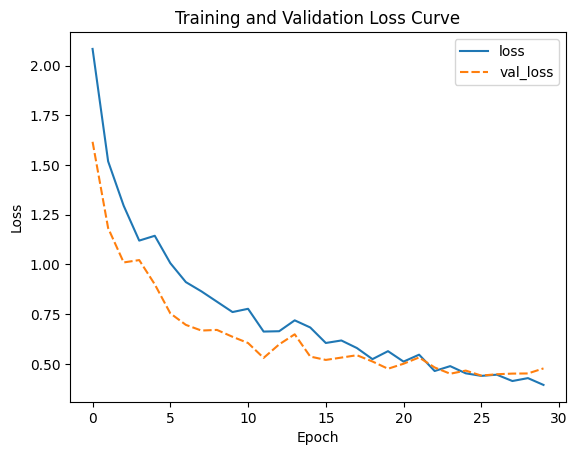

In [32]:
history_df = pd.DataFrame(history.history)
sns.lineplot(data=history_df[['loss','val_loss']]).set(title="Training and Validation Loss Curve", xlabel="Epoch", ylabel="Loss")

In [33]:
training_loss, training_accuracy = model.evaluate(train_dataset)
validation_loss, validation_accuracy = model.evaluate(validation_dataset)


print(f"Training Loss: {training_loss}, Training Accuracy: {training_accuracy}")
print(f"Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.9110 - loss: 0.2790
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8289 - loss: 0.4949
Training Loss: 0.26042819023132324, Training Accuracy: 0.9219047427177429
Validation Loss: 0.47744131088256836, Validation Accuracy: 0.845714271068573
